In [16]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.stats as ss, scipy.integrate as integrate

## some admin stuff

In [21]:
# thankful to this stackoverflow answer:
# https://stackoverflow.com/a/49199019
import pkg_resources, types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))
reqs = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        reqs.append((m.project_name, m.version))

for r in reqs:
    print(f'{r[0]}={r[1]}')

scipy=1.7.1
pandas=1.3.4
numpy=1.20.3
matplotlib=3.4.3


[]

In [48]:
df = pd.read_csv('data/stations.csv')

In [59]:
date_df = pd.concat([df['STATION_NUMBER'],
                     df['COUNTY_NAME'],
                     df['STATION_TYPE'],
                     pd.to_datetime(df['SAMPLE_DATE_MIN']),
                     pd.to_datetime(df['SAMPLE_DATE_MAX'])], axis=1)

In [60]:
print(date_df)

      STATION_NUMBER   COUNTY_NAME   STATION_TYPE     SAMPLE_DATE_MIN  \
0      01N01E01A001M          Yolo    Groundwater 2008-06-23 15:00:00   
1      01N01E33K001M  Contra Costa    Groundwater 1981-05-20 13:45:00   
2      01N01W03N001M  Contra Costa    Groundwater 1974-07-23 15:15:00   
3      01N01W04A001M  Contra Costa    Groundwater 1972-08-04 15:00:00   
4      01N01W07K001M  Contra Costa    Groundwater 1973-08-03 09:30:00   
...              ...           ...            ...                 ...   
43807       Z8363610   Los Angeles  Surface Water 1972-05-24 09:00:00   
43808       Z8363710   Los Angeles  Surface Water 1972-05-24 08:30:00   
43809       Z8363910   Los Angeles  Surface Water 1972-05-24 08:00:00   
43810       Z8364010   Los Angeles  Surface Water 1972-05-24 07:30:00   
43811       Z8517000   Los Angeles  Surface Water 1968-09-16 07:45:00   

          SAMPLE_DATE_MAX  
0     2008-06-23 15:00:00  
1     1981-05-20 13:45:00  
2     1990-08-16 12:15:00  
3     1989-

In [315]:
date_df['TOTAL_UPTIME'] = date_df["SAMPLE_DATE_MAX"] - date_df["SAMPLE_DATE_MIN"]
date_df

,STATION_NUMBER,COUNTY_NAME,STATION_TYPE,SAMPLE_DATE_MIN,SAMPLE_DATE_MAX,TOTAL_UPTIME
0,01N01E01A001M,Yolo,Groundwater,2008-06-23 15:00:00,2008-06-23 15:00:00,0 days 00:00:00
1,01N01E33K001M,Contra Costa,Groundwater,1981-05-20 13:45:00,1981-05-20 13:45:00,0 days 00:00:00
2,01N01W03N001M,Contra Costa,Groundwater,1974-07-23 15:15:00,1990-08-16 12:15:00,5867 days 21:00:00
3,01N01W04A001M,Contra Costa,Groundwater,1972-08-04 15:00:00,1989-09-15 08:00:00,6250 days 17:00:00
4,01N01W07K001M,Contra Costa,Groundwater,1973-08-03 09:30:00,1989-09-15 09:15:00,5886 days 23:45:00
...,...,...,...,...,...,...
43807,Z8363610,Los Angeles,Surface Water,1972-05-24 09:00:00,1972-05-24 09:00:00,0 days 00:00:00
43808,Z8363710,Los Angeles,Surface Water,1972-05-24 08:30:00,1972-05-24 08:30:00,0 days 00:00:00
43809,Z8363910,Los Angeles,Surface Water,1972-05-24 08:00:00,1972-05-24 08:00:00,0 days 00:00:00
43810,Z8364010,Los Angeles,Surface Water,1972-05-24 07:30:00,1972-05-24 07:30:00,0 days 00:00:00


## Uptime data!

In [309]:
uptimes_int = date_df['TOTAL_UPTIME'].dt.days.dropna()
uptimes = date_df['TOTAL_UPTIME'].dt.total_seconds().dropna() / (24 * 60 * 60)
uptime_no_zeros = uptimes.where(uptimes > 0).dropna()
uptime_zeros = uptimes.where(uptimes == 0).dropna()

In [202]:
print(uptimes)

0           0.000000
1           0.000000
2        5867.875000
3        6250.708333
4        5886.989583
            ...     
43807       0.000000
43808       0.000000
43809       0.000000
43810       0.000000
43811    3611.906250
Name: TOTAL_UPTIME, Length: 43812, dtype: float64


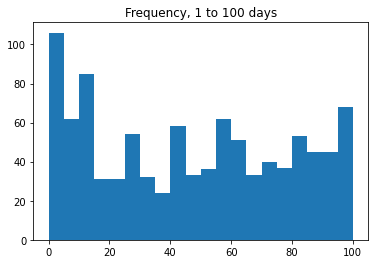

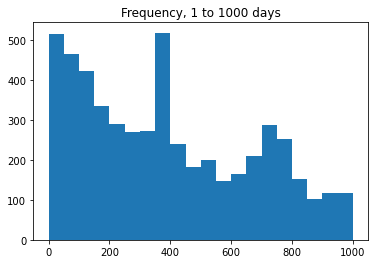

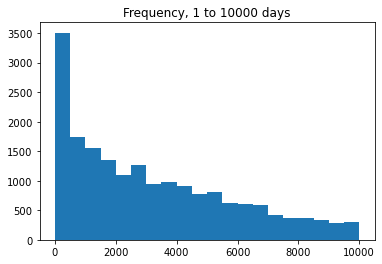

In [197]:
sorted_days = uptime_no_zeros.sort_values()
frequency_plot = plt.hist(uptime_no_zeros,bins=20, range=(0, 100))
plt.title('Frequency, 1 to 100 days')
plt.show()
frequency_plot_2 = plt.hist(uptime_no_zeros,bins=20, range=(0, 1000))
plt.title('Frequency, 1 to 1000 days')
plt.show()
frequency_plot_3 = plt.hist(uptime_no_zeros,bins=20, range=(0, 10000))
plt.title('Frequency, 1 to 10000 days')
plt.show()

This roughly fits an exponential distribution, with a few outliers here and there. Here's some basic statistics, as well as the probability curve for the uptime data that isn't 0.

In [311]:
# no zeros
mean, std, var, med = (uptime_no_zeros.mean(),
                  uptime_no_zeros.std(),
                  uptime_no_zeros.var(),
                      uptime_no_zeros.median()
                      )
print(f'''
    Mean: {mean},
    Std. Dev: {std},
    Variance: {var},
    Median: {med}
    Zeros: {uptime_zeros.count()}
''')
print(uptime_no_zeros.count())
print(uptime_no_zeros.where(uptime_no_zeros < (mean + 2 * std)).count())


    Mean: 4202.745104270784,
    Std. Dev: 4256.508935215438,
    Variance: 18117868.31556886,
    Median: 2942.0625
    Zeros: 22468

21344
20252


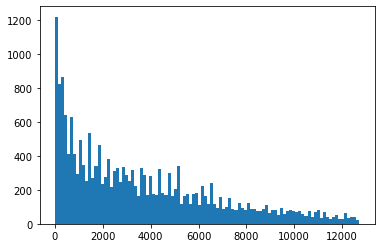

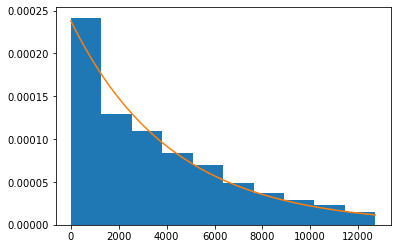

0.0006944444444444446


In [312]:
 _, bins, _ = plt.hist(uptime_no_zeros, bins=100, range=(1, mean + 2 * std))
plt.show()

best_fit = ss.expon.fit(uptime_no_zeros)
pdist = ss.expon.pdf(bins, *best_fit)
rate, mu = best_fit

density_funtion = plt.hist(uptime_no_zeros, density=True, range=(1, mean + 2 * std))
plt.plot(bins, pdist)
plt.show()
# uptime_pdf = ss.expon.pdf(bins, *best_fit)
# plt.hist(uptime_no_zeros)
print(rate)

In [313]:
step_width = 1000
def prange(lower=0):
    return integrate.quad(lambda x: rate * np.exp(-rate * x), lower, lower + step_width)[0]


range_column = pd.Series(np.arange(0, np.floor(mean + 2 * std), step_width))
range_column_names = range_column.apply(lambda n: f'{n} to {n + step_width}') 
prob_column = range_column.apply(prange)


probabilities_ranges = pd.concat([range_column, range_column_names, prob_column], axis=1)
probabilities_ranges

,0,1,2
0,0.0,0.0 to 1000.0,0.500648
1,1000.0,1000.0 to 2000.0,0.250000
2,2000.0,2000.0 to 3000.0,0.124838
3,3000.0,3000.0 to 4000.0,0.062338
4,4000.0,4000.0 to 5000.0,0.031129
5,5000.0,5000.0 to 6000.0,0.015544
6,6000.0,6000.0 to 7000.0,0.007762
7,7000.0,7000.0 to 8000.0,0.003876
8,8000.0,8000.0 to 9000.0,0.001935
9,9000.0,9000.0 to 10000.0,0.000966


## Some other stuff

To start out, let's see what the longest surviving stations ever were. I'm curious to know if there are any in the top 15 that exist within my county.

In [103]:
date_df.sort_values(by=['TOTAL_UPTIME'], 
                    axis=0, ascending=False)[:15]

,STATION_NUMBER,COUNTY_NAME,STATION_TYPE,SAMPLE_DATE_MIN,SAMPLE_DATE_MAX,TOTAL_UPTIME
43263,V9162000,San Bernardino,Surface Water,1908-03-17 00:00:00,2002-05-01 12:00:00,34378 days 12:00:00
43593,Z2130000,Ventura,Surface Water,1917-07-10 00:00:00,2002-05-06 11:20:00,30981 days 11:20:00
33012,27N03W28A001M,Tehama,Groundwater,1935-10-08 00:00:00,2013-10-15 13:05:00,28497 days 13:05:00
12506,05N09W25A001S,Los Angeles,Groundwater,1913-05-13 13:30:00,1991-04-16 11:00:00,28461 days 21:30:00
21193,11N34W30D002S,San Luis Obispo,Groundwater,1907-11-05 15:20:00,1981-10-20 14:20:00,27012 days 23:00:00
38869,A0510300,Sutter,Surface Water,1949-03-14 00:00:00,2021-10-27 12:30:00,26525 days 12:30:00
41789,E6525000,Santa Clara,Surface Water,1949-03-07 00:00:00,2021-05-13 09:40:00,26365 days 09:40:00
42473,F9150000,Sonoma,Surface Water,1950-07-13 00:00:00,2021-10-28 12:34:00,26040 days 12:34:00
42542,F9420000,Mendocino,Surface Water,1950-10-26 15:30:00,2021-10-28 09:56:00,25934 days 18:26:00
42726,G7119500,Nevada,Surface Water,1951-04-18 10:45:00,2021-12-08 11:45:00,25802 days 01:00:00


Now, let's just experiment a bit with `SAMPLE_DATE_MIN` and `SAMPLE_DATE_MAX`. I wonder how far back this dataset goes, and I'm curious to see what the newest ever station is.

In [100]:
date_df.sort_values(by=['SAMPLE_DATE_MIN'], 
                    axis=0, ascending=False)[:10]

,STATION_NUMBER,COUNTY_NAME,STATION_TYPE,SAMPLE_DATE_MIN,SAMPLE_DATE_MAX,TOTAL_UPTIME
40677,B9D81651399,Yolo,Surface Water,2019-08-07 11:59:00,2021-10-13 09:58:00,797 days 21:59:00
40654,B9D81450411,Yolo,Surface Water,2019-08-07 10:59:00,2021-10-13 08:48:00,797 days 21:49:00
40638,B9D81281402,Yolo,Surface Water,2019-08-07 10:23:00,2021-10-13 08:14:00,797 days 21:51:00
38647,A0033300,Yolo,Surface Water,2019-08-06 08:53:00,2021-09-27 08:09:00,782 days 23:16:00
38709,A0200000,Sacramento,Surface Water,2019-08-05 09:14:00,2021-10-12 08:24:00,798 days 23:10:00
31453,24N02W27G004M,Tehama,Groundwater,2019-07-17 08:45:00,2019-07-17 08:45:00,0 days 00:00:00
30155,21N02E31M001M,Butte,Groundwater,2019-06-19 10:40:00,2020-12-01 09:15:00,530 days 22:35:00
30151,21N02E30M001M,Butte,Groundwater,2019-06-19 10:00:00,2020-12-01 09:40:00,530 days 23:40:00
30132,21N01E25A001M,Butte,Groundwater,2019-06-19 09:30:00,2020-12-01 09:00:00,530 days 23:30:00
30837,22N03E15P001M,Butte,Groundwater,2019-03-28 12:45:00,2019-03-28 12:45:00,0 days 00:00:00


In [101]:
date_df.sort_values(by=['SAMPLE_DATE_MIN'], 
                    axis=0, ascending=True)[:10]

,STATION_NUMBER,COUNTY_NAME,STATION_TYPE,SAMPLE_DATE_MIN,SAMPLE_DATE_MAX,TOTAL_UPTIME
24574,14N16E13X001S,San Bernardino,Groundwater,1903-03-23 00:00:00,1903-03-23 00:00:00,0 days 00:00:00
12600,05N15E04B001S,San Bernardino,Groundwater,1903-09-26 00:00:00,1903-09-26 00:00:00,0 days 00:00:00
21193,11N34W30D002S,San Luis Obispo,Groundwater,1907-11-05 15:20:00,1981-10-20 14:20:00,27012 days 23:00:00
43263,V9162000,San Bernardino,Surface Water,1908-03-17 00:00:00,2002-05-01 12:00:00,34378 days 12:00:00
18394,09N03W33Z001S,San Bernardino,Groundwater,1908-07-20 00:00:00,1908-07-20 00:00:00,0 days 00:00:00
36972,32S23E24N001M,Kern,Groundwater,1909-04-01 00:00:00,1909-04-01 00:00:00,0 days 00:00:00
36031,30S37E24X002M,Kern,Groundwater,1909-06-07 00:00:00,1909-06-07 00:00:00,0 days 00:00:00
3261,01S20E14L001S,San Bernardino,Groundwater,1910-07-02 00:00:00,1910-07-02 00:00:00,0 days 00:00:00
9514,04N15E24E001S,San Bernardino,Groundwater,1910-07-12 00:00:00,1910-07-12 00:00:00,0 days 00:00:00
3297,01S23E01A002S,San Bernardino,Groundwater,1910-08-11 00:00:00,1910-08-11 00:00:00,0 days 00:00:00
